In [1]:
from src.model import VAE
from src.trainer import CDVAETrainer
from src.utils import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# %%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [5]:
from src.utils import StyledMNISTGenerator, StyledMNIST

In [6]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11, device=device)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11, device=device)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [7]:
np.random.seed(101)
torch.manual_seed(101)

In [8]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.15,
        corruptions.stripe: 0.2,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.1,
        lambda x: corruptions.scale(x, 5): 0.1,
        corruptions.brightness: 0.2
    },
)


In [9]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:13<00:00, 4381.07item/s]


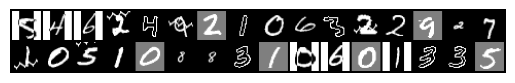

In [10]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


### cosine sim + label-flipping

In [33]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [1e2, 1e2]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [34]:
trainer.fit(51, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 223.55it/s]


val_recontr_loss=59.114, val_kl_c=10.709, val_kl_s=14.841, val_c_loss=0.258, val_s_loss=0.114
gMIG: 0.194; elbo: -84.664


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 247.23it/s]


val_recontr_loss=28.935, val_kl_c=12.480, val_kl_s=18.365, val_c_loss=0.124, val_s_loss=0.113
gMIG: 0.257; elbo: -59.78


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 246.89it/s]


val_recontr_loss=22.822, val_kl_c=14.355, val_kl_s=20.102, val_c_loss=0.105, val_s_loss=0.113
gMIG: 0.275; elbo: -57.279


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 244.25it/s]


val_recontr_loss=20.995, val_kl_c=14.735, val_kl_s=20.443, val_c_loss=0.105, val_s_loss=0.112
gMIG: 0.283; elbo: -56.173


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 246.58it/s]


val_recontr_loss=19.372, val_kl_c=15.061, val_kl_s=21.243, val_c_loss=0.095, val_s_loss=0.111
gMIG: 0.287; elbo: -55.677


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 239.40it/s]


val_recontr_loss=17.897, val_kl_c=15.407, val_kl_s=21.878, val_c_loss=0.092, val_s_loss=0.109
gMIG: 0.292; elbo: -55.182


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 240.96it/s]


val_recontr_loss=16.593, val_kl_c=15.666, val_kl_s=21.915, val_c_loss=0.091, val_s_loss=0.111
gMIG: 0.295; elbo: -54.175


val-epoch 35: 100%|██████████| 79/79 [00:00<00:00, 243.86it/s]


val_recontr_loss=16.236, val_kl_c=16.348, val_kl_s=22.376, val_c_loss=0.095, val_s_loss=0.110
gMIG: 0.304; elbo: -54.959


val-epoch 40: 100%|██████████| 79/79 [00:00<00:00, 255.69it/s]


val_recontr_loss=16.006, val_kl_c=16.485, val_kl_s=21.685, val_c_loss=0.091, val_s_loss=0.110
gMIG: 0.295; elbo: -54.176


val-epoch 45: 100%|██████████| 79/79 [00:00<00:00, 243.82it/s]


val_recontr_loss=15.343, val_kl_c=16.643, val_kl_s=21.839, val_c_loss=0.086, val_s_loss=0.109
gMIG: 0.302; elbo: -53.825


val-epoch 50: 100%|██████████| 79/79 [00:00<00:00, 244.23it/s]


val_recontr_loss=15.578, val_kl_c=16.994, val_kl_s=21.822, val_c_loss=0.099, val_s_loss=0.110
gMIG: 0.303; elbo: -54.394


In [35]:
trainer.evaluate(test_loader, False, 0)

(0.3048140478549293, -54.195412340255594)

In [36]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:00<00:00, 401.28it/s]


In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

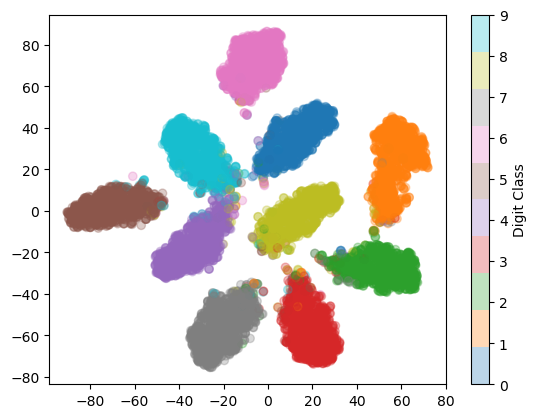

In [38]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

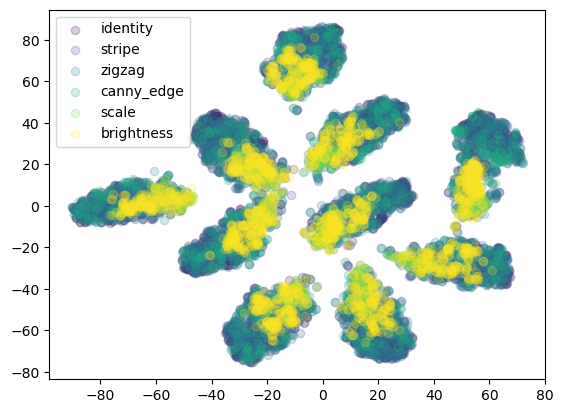

In [39]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [40]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

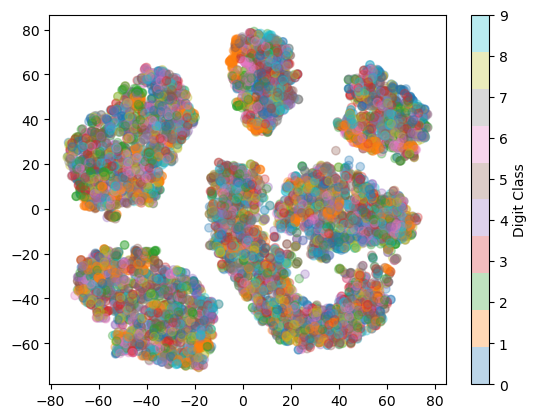

In [41]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

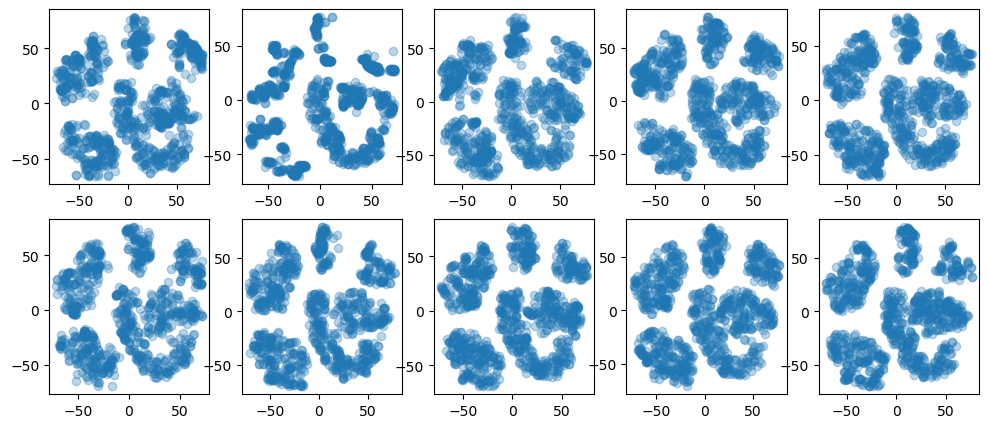

In [42]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

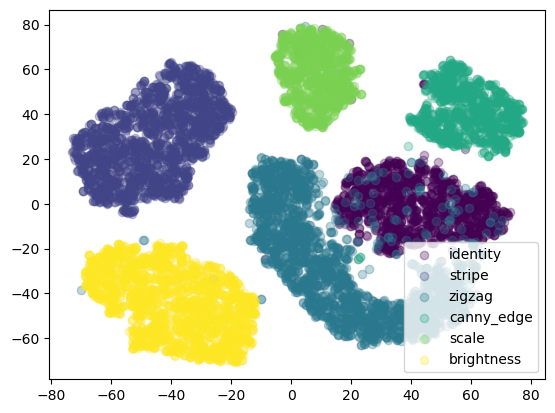

In [43]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [44]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [45]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

interpolate style:


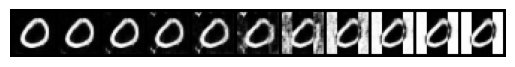

interpolate content:


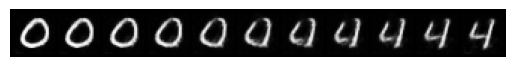

In [47]:
display_util(8, 1, z, vae, int(Z_DIM / 2))

### l2 sim + lable-flipping

In [69]:
Z_DIM = 16
TEMP = 0.1
ALPHA = [100, 100]
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="l2",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [70]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 240.12it/s]


val_recontr_loss=63.332, val_kl_c=10.708, val_kl_s=9.996, val_c_loss=0.460, val_s_loss=0.123
gMIG: 0.123; elbo: -84.037


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 219.26it/s]


val_recontr_loss=36.467, val_kl_c=14.066, val_kl_s=13.946, val_c_loss=0.178, val_s_loss=0.126
gMIG: 0.197; elbo: -64.48


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 196.35it/s]


val_recontr_loss=28.131, val_kl_c=16.861, val_kl_s=17.266, val_c_loss=0.187, val_s_loss=0.122
gMIG: 0.24; elbo: -62.259


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 195.75it/s]


val_recontr_loss=26.922, val_kl_c=17.470, val_kl_s=19.826, val_c_loss=0.176, val_s_loss=0.117
gMIG: 0.256; elbo: -64.217


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 204.13it/s]


val_recontr_loss=22.146, val_kl_c=18.060, val_kl_s=21.618, val_c_loss=0.181, val_s_loss=0.116
gMIG: 0.265; elbo: -61.825


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 204.48it/s]


val_recontr_loss=21.515, val_kl_c=18.305, val_kl_s=22.850, val_c_loss=0.161, val_s_loss=0.114
gMIG: 0.268; elbo: -62.67


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 195.26it/s]


val_recontr_loss=21.867, val_kl_c=18.312, val_kl_s=23.556, val_c_loss=0.176, val_s_loss=0.114
gMIG: 0.275; elbo: -63.736


In [168]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [169]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

In [ ]:
display_util(9, 26, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [35]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 9
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [53, 88, 62, 67, 73, 85, 71, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### mahalanobis + label flipping

In [63]:
Z_DIM = 16
TEMP = 0.3
ALPHA = [5, 5]
LABEL_FLIPPING = True

In [64]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="mahalanobis",
    hyperparameter={"temperature": TEMP, "beta": 1/128, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [65]:
trainer.fit(41, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 244.32it/s]


val_recontr_loss=54.400, val_kl_c=6.317, val_kl_s=38.642, val_c_loss=0.673, val_s_loss=0.213
gMIG: 0.07; elbo: -99.36


val-epoch 5: 100%|██████████| 79/79 [00:01<00:00, 59.76it/s]


val_recontr_loss=33.868, val_kl_c=8.708, val_kl_s=18.518, val_c_loss=0.831, val_s_loss=0.284
gMIG: 0.121; elbo: -61.094


val-epoch 10: 100%|██████████| 79/79 [00:01<00:00, 55.22it/s]


val_recontr_loss=30.848, val_kl_c=9.444, val_kl_s=15.015, val_c_loss=0.893, val_s_loss=0.317
gMIG: 0.146; elbo: -55.306


val-epoch 15: 100%|██████████| 79/79 [00:01<00:00, 59.14it/s]


val_recontr_loss=29.212, val_kl_c=10.292, val_kl_s=16.491, val_c_loss=1.154, val_s_loss=0.299
gMIG: 0.157; elbo: -55.996


val-epoch 20: 100%|██████████| 79/79 [00:01<00:00, 62.06it/s]


val_recontr_loss=27.908, val_kl_c=12.153, val_kl_s=16.206, val_c_loss=1.678, val_s_loss=0.314
gMIG: 0.176; elbo: -56.266


val-epoch 25: 100%|██████████| 79/79 [00:01<00:00, 62.41it/s]


val_recontr_loss=27.125, val_kl_c=12.213, val_kl_s=19.596, val_c_loss=1.479, val_s_loss=0.328
gMIG: 0.179; elbo: -58.933


val-epoch 30: 100%|██████████| 79/79 [00:01<00:00, 73.80it/s]


val_recontr_loss=26.671, val_kl_c=12.651, val_kl_s=17.245, val_c_loss=1.673, val_s_loss=0.313
gMIG: 0.178; elbo: -56.567


val-epoch 35: 100%|██████████| 79/79 [00:01<00:00, 66.42it/s]


val_recontr_loss=26.250, val_kl_c=12.852, val_kl_s=17.821, val_c_loss=1.595, val_s_loss=0.317
gMIG: 0.185; elbo: -56.923


val-epoch 40: 100%|██████████| 79/79 [00:01<00:00, 58.85it/s]


val_recontr_loss=25.773, val_kl_c=12.815, val_kl_s=16.764, val_c_loss=1.948, val_s_loss=0.295
gMIG: 0.187; elbo: -55.352


In [61]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

interpolate style:


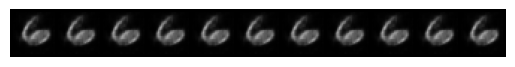

interpolate content:


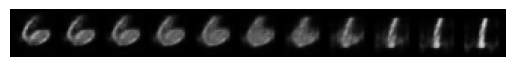

In [62]:
display_util(9, 16, z, vae, 16)

interpolate style:


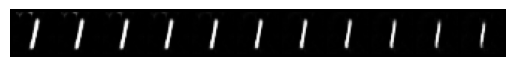

interpolate content:


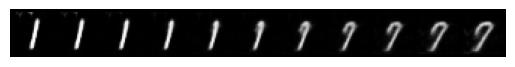

In [129]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

interpolate style:


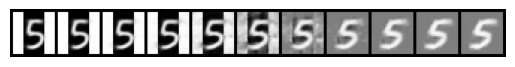

interpolate content:


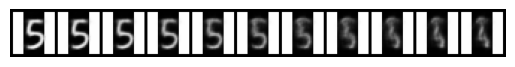

In [130]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

interpolate style:


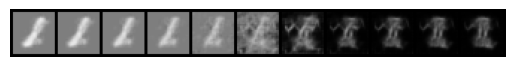

interpolate content:


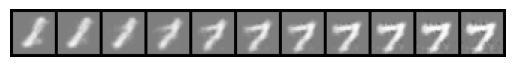

In [131]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

interpolate style:


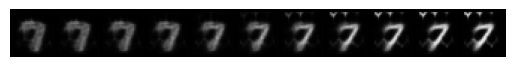

interpolate content:


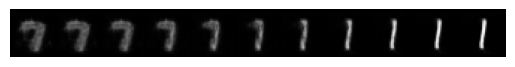

In [132]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [133]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

100%|██████████| 79/79 [00:00<00:00, 291.75it/s]


In [134]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

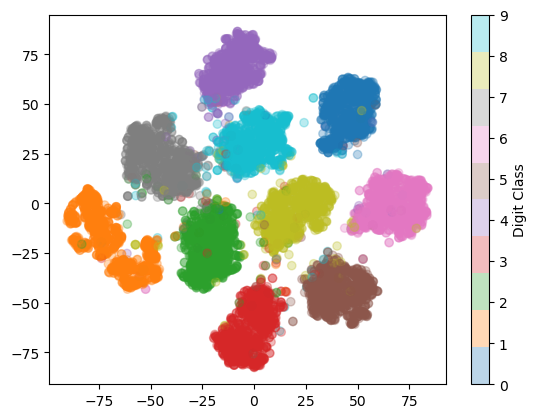

In [135]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

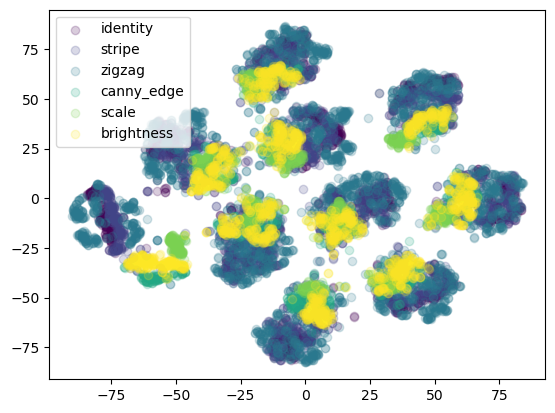

In [141]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [142]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

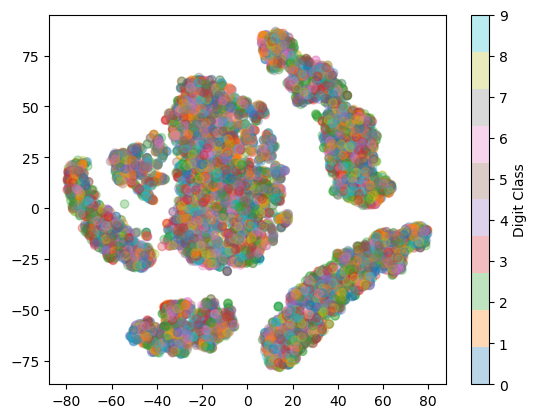

In [143]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

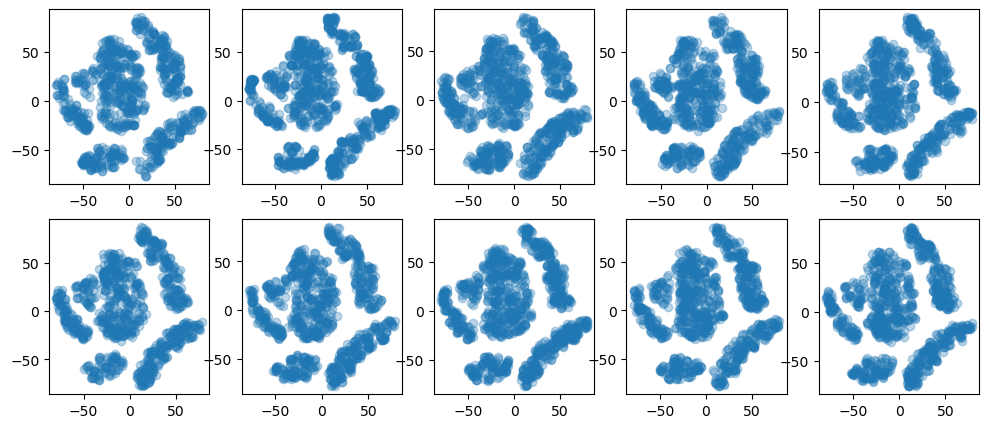

In [144]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

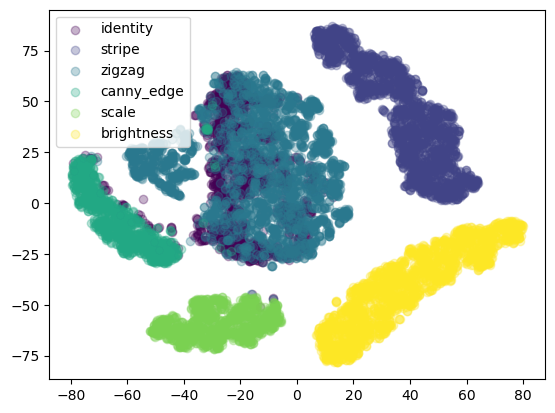

In [145]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [136, 120, 84, 50, 52]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))